In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
filepath = "/content/drive/MyDrive/SP500_Shiller.csv"
data = pd.read_csv(filepath)
data.head()

,Date,S&P 500 Historical Prices by Month,Inflation Adjusted S&P 500 by Month,Shiller PE Ration by Month
0,1-Jan-60,58.03,520.91,18.34
1,1-Feb-60,55.78,499.01,17.55
2,1-Mar-60,55.02,492.21,17.29
3,1-Apr-60,55.73,496.87,17.43
4,1-May-60,55.22,492.33,17.26


In [4]:
data['S&P 500 Historical Prices by Month'] = data['S&P 500 Historical Prices by Month'].apply(lambda x: x.replace(',', '')).astype('float')
data['Inflation Adjusted S&P 500 by Month'] = data['Inflation Adjusted S&P 500 by Month'].apply(lambda x: x.replace(',', '')).astype('float')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Date                                 733 non-null    object 
 1   S&P 500 Historical Prices by Month   733 non-null    float64
 2   Inflation Adjusted S&P 500 by Month  733 non-null    float64
 3   Shiller PE Ration by Month           733 non-null    float64
dtypes: float64(3), object(1)
memory usage: 23.0+ KB


In [6]:
data.describe()

,S&P 500 Historical Prices by Month,Inflation Adjusted S&P 500 by Month,Shiller PE Ration by Month
count,733.000000,733.000000,733.000000
mean,741.750259,1127.960177,20.573588
std,813.487111,756.277108,7.967296
min,53.730000,295.120000,6.640000
25%,100.600000,568.750000,15.060000
50%,346.600000,746.590000,20.530000
75%,1222.240000,1625.840000,25.680000
max,3793.750000,3814.520000,44.190000


In [7]:
#计算 Shiller PE Ration by Month 均值
PE_mean = data['Shiller PE Ration by Month'].mean()
PE_mean_array = np.array([PE_mean]*len(data))

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#折线图 sp500 secondary_y=True
#柱状图 shiller secondary_y=False
fig = make_subplots(specs=[[{"secondary_y": True}]],)

#Shiller PE Ration by Month
fig.add_trace(go.Scatter(x=data['Date'], y=data['Shiller PE Ration by Month'],
                     name='Shiller PE',
                     marker=dict(color='rgb(26, 118, 255)')),
             secondary_y=False)
#S&P 500 Historical Prices by Month
fig.add_trace(go.Scatter(x=data['Date'], y=data['S&P 500 Historical Prices by Month'],
                        #  mode='lines',
                         name='S&P 500'),
             secondary_y=True)

#Mean of Shiller PE Ration by Month
fig.add_trace(go.Scatter(x=data['Date'], y=PE_mean_array,
                         mode='lines',
                         name='Mean of Shiller PE'),
             secondary_y=False)

fig.update_layout(
    title_text="Shiller PE vs S&P 500"
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Shiller PE Ration by Month", secondary_y=False)
fig.update_yaxes(title_text="S&P 500 Prices by Month", secondary_y=True, nticks=5)

fig.show()

In [9]:
import tensorflow as tf 
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

# Define Model
in this part we define two models<br>
1. CNN + LSTM: we think convolution may help to find some better pattern
2. just use LSTM: we are not sure if adding CNN may help. It may also cause some overfitting or gradient explosion problems
3. while using LSTM, we also try two kinds of models: 
    1. LSTM + dense
    2. LSTM
4. using relu as activation function. the gradient may vanish when relu cut the negative part to 0, anyway, let's try



In [10]:
# we should not use batchnormaliation because the sample are not from the same distribution
# but maybe we can try layernormalzation
def get_model1(input_length=180, normalized=False, activation=True):
    if activation:
        ipt = Input(shape=(input_length, 2))
        cnn1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same',activation='relu')(ipt)
        if normalized:
            cnn_norm = LayerNormalization(axis=-1)(cnn1)
            lstm1 = LSTM(4, return_sequences=False, activation='relu')(cnn_norm)
        else:
            lstm1 = LSTM(4, return_sequences=False, activation='relu')(cnn1)
        opt = Dense(1, activation='relu')(lstm1)
        model = Model(ipt, opt)
        return model
    else:
        ipt = Input(shape=(input_length, 2))
        cnn1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same')(ipt)
        if normalized:
            cnn_norm = LayerNormalization(axis=-1)(cnn1)
            lstm1 = LSTM(4, return_sequences=False)(cnn_norm)
        else:
            lstm1 = LSTM(4, return_sequences=False)(cnn1)
        opt = Dense(1)(lstm1)
        model = Model(ipt, opt)
        return model

In [11]:
def get_model2(input_length=180, activation=True):
    ipt = Input(shape=(input_length, 2))
    lstm = LSTM(4, return_sequences=False, activation='relu')(ipt) if activation else LSTM(4, return_sequences=False)(ipt)
    opt = Dense(1, activation='relu')(lstm)
    model = Model(ipt, opt)
    return model


In [12]:
def get_model3(input_length=180):
    ipt = Input(shape=(input_length, 2))
    opt = LSTM(1, return_sequences=False)(ipt)
    model = Model(ipt, opt)
    return model

# Make dataset
we multiply shiller PE by 40 before training the model,to pay more attention on this feature<br>40 is a constant number, there is no data leak

In [63]:
alpha = 40

In [64]:
data['label'] = data['S&P 500 Historical Prices by Month']

In [65]:
# use P/E to predict S&P  (maybe, if not change the following codes)
features = data[['S&P 500 Historical Prices by Month','Shiller PE Ration by Month']].values
features = [[f[0], f[1]*alpha] for f in features]
labels = data['label'][180: ]

In [66]:
data_X = np.array([features[i:i+180] for i in range(len(features)-180)])
data_Y = np.array(labels)
assert len(data_X) == len(data_Y)
data_X.shape, data_Y.shape

((553, 180, 2), (553,))

In [67]:
# split
def train_test_split(dataset_X, dataset_Y, split=0.3):
    train_len = int(len(dataset_X) * (1-split))

    train_X = dataset_X[0:train_len].reshape((-1, 180, 2))
    train_Y = dataset_Y[0:train_len]

    test_X = dataset_X[train_len:].reshape((-1, 180, 2))
    test_Y = dataset_Y[train_len:]

    return train_X, train_Y, test_X, test_Y

In [68]:
train_X, train_Y, test_X, test_Y = train_test_split(data_X, data_Y, split=0.15)

In [69]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((470, 180, 2), (470,), (83, 180, 2), (83,))

In [70]:
max(train_Y), max(test_Y)

(1822.36, 3793.75)

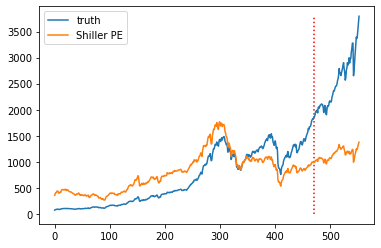

In [71]:
total_Y = np.concatenate((train_Y, test_Y), axis=0)
x_range = np.arange(len(total_Y))
plt.plot(x_range, total_Y, label='truth')
plt.plot(x_range, [feature[1] for feature in features][180:], label='Shiller PE')
plt.legend()
plt.vlines(x=len(train_X), ymin=0, ymax=max(total_Y), colors='r', linestyles='dotted')
plt.show()

# it may not work using Shiller PE to predict, because the pattern in test set and the pattern in train set are not similar

# Model1: CNN + LSTM + Dense
let try without activation and with activation

In [ ]:
model_cnn_lstm_dense = get_model1(input_length=180, normalized=False, activation=False)

don't know whether mae or mse is a good loss function. <br>
with mse, the loss is (y_pred-y_truth) ** 2, the gradient is related to y_pred-y_truth and x_train. so the gradeint may be super large <br>
so let's start from mae <br>
later on, we may use a customized loss function

In [ ]:
model_cnn_lstm_dense.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 180, 2)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 180, 8)            56        
_________________________________________________________________
lstm_8 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 269
Trainable params: 269
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_cnn_lstm_dense.compile(optimizer='adam', loss='mae')

In [ ]:
checkpoint_filepath = './checkpoints/model_weights_cnn_lstm_dense.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history = model_cnn_lstm_dense.fit(train_X, train_Y, batch_size=8, epochs=1000, validation_data=(test_X, test_Y), callbacks=[model_checkpoint_callback])

Epoch 1/1000
56/56 [==============================] - 1s 9ms/step - loss: 618.1107 - val_loss: 2258.1873
Epoch 2/1000
56/56 [==============================] - 0s 8ms/step - loss: 617.9559 - val_loss: 2258.0637
Epoch 3/1000
56/56 [==============================] - 0s 8ms/step - loss: 617.8011 - val_loss: 2257.9404
Epoch 4/1000
56/56 [==============================] - 0s 8ms/step - loss: 617.6464 - val_loss: 2257.8169
Epoch 5/1000
56/56 [==============================] - 0s 8ms/step - loss: 617.4916 - val_loss: 2257.6936
Epoch 6/1000
56/56 [==============================] - 0s 8ms/step - loss: 617.3370 - val_loss: 2257.5703
Epoch 7/1000
56/56 [==============================] - 0s 8ms/step - loss: 617.1823 - val_loss: 2257.4470
Epoch 8/1000
56/56 [==============================] - 0s 9ms/step - loss: 617.0275 - val_loss: 2257.3237
Epoch 9/1000
56/56 [==============================] - 0s 9ms/step - loss: 616.8728 - val_loss: 2257.2002
Epoch 10/1000
56/56 [==============================] - 

In [ ]:
model_cnn_lstm_dense.save_weights('model_cnn_lstm_dense_epochs1000.h5')

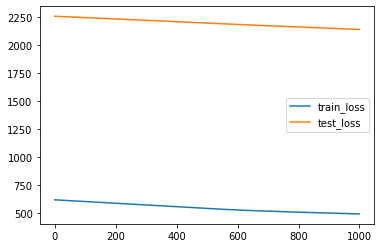

In [ ]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x_range = [i for i in range(len(train_loss))]
plt.plot(x_range, train_loss, label='train_loss')
plt.plot(x_range, test_loss, label='test_loss')
plt.legend()
plt.show()


it is learning, but too slow, let's training for some more epochs

In [ ]:
history = model_cnn_lstm_dense.fit(train_X, train_Y, batch_size=8, epochs=10000, validation_data=(test_X, test_Y))

Streaming output truncated to the last 5000 lines.
Epoch 7501/10000
56/56 [==============================] - 1s 10ms/step - loss: 421.1920 - val_loss: 1908.7493
Epoch 7502/10000
56/56 [==============================] - 1s 10ms/step - loss: 421.1911 - val_loss: 1908.7429
Epoch 7503/10000
56/56 [==============================] - 1s 10ms/step - loss: 421.1911 - val_loss: 1908.7452
Epoch 7504/10000
56/56 [==============================] - 1s 10ms/step - loss: 421.1917 - val_loss: 1908.7433
Epoch 7505/10000
56/56 [==============================] - 1s 11ms/step - loss: 421.1913 - val_loss: 1908.7494
Epoch 7506/10000
56/56 [==============================] - 1s 11ms/step - loss: 421.1917 - val_loss: 1908.7557
Epoch 7507/10000
56/56 [==============================] - 1s 11ms/step - loss: 421.1915 - val_loss: 1908.7506
Epoch 7508/10000
56/56 [==============================] - 1s 11ms/step - loss: 421.1913 - val_loss: 1908.7482
Epoch 7509/10000
56/56 [==============================] - 1s 11ms/ste

In [ ]:
model_cnn_lstm_dense.save_weights('/content/drive/MyDrive/model_cnn_lstm_dense_epochs10000.h5')

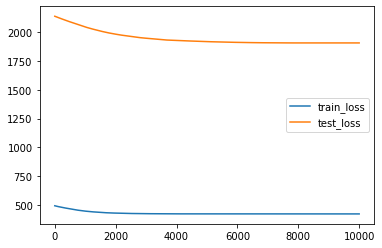

In [ ]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x_range = [i for i in range(len(train_loss))]
plt.plot(x_range, train_loss, label='train_loss')
plt.plot(x_range, test_loss, label='test_loss')
plt.legend()
plt.show()

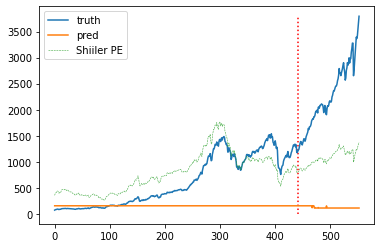

In [ ]:
total_X = np.concatenate((train_X, test_X), axis=0)
total_Y = np.concatenate((train_Y, test_Y), axis=0)
y_pred = model_cnn_lstm_dense.predict(total_X)
x_range = np.arange(len(total_X))
y_truth = total_Y
plt.plot(x_range, y_truth, label='truth')
plt.plot(x_range, y_pred, label='pred')
plt.plot(x_range, [f[1] for f in features[180:]], label='Shiiler PE', linestyle='dashed', linewidth=0.5)
plt.legend()
plt.vlines(x=len(train_X), ymin=0, ymax=max(total_Y), colors='r', linestyles='dotted')
plt.show()

# Model2: LSTM + Dense

In [ ]:
model_lstm_dense = get_model2(input_length=180)

In [ ]:
model_lstm_dense.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 2)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 112       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm_dense.compile(optimizer='adam', loss='mae')

In [ ]:
checkpoint_filepath = './checkpoints/model_weights_lstm_dense.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history = model_lstm_dense.fit(train_X, train_Y, batch_size=16, epochs=100, validation_data=(test_X, test_Y), callbacks=[model_checkpoint_callback])

Epoch 1/100
28/28 [==============================] - 6s 229ms/step - loss: 400.6698 - val_loss: 1565.5746
Epoch 2/100
28/28 [==============================] - 6s 232ms/step - loss: 421.8807 - val_loss: 1692.0343
Epoch 3/100
28/28 [==============================] - 6s 229ms/step - loss: 417.4111 - val_loss: 1657.2263
Epoch 4/100
28/28 [==============================] - 7s 236ms/step - loss: 401.4525 - val_loss: 1641.1967
Epoch 5/100
28/28 [==============================] - 6s 228ms/step - loss: 398.2318 - val_loss: 1628.7058
Epoch 6/100
28/28 [==============================] - 7s 238ms/step - loss: 388.1212 - val_loss: 1636.4498
Epoch 7/100
28/28 [==============================] - 6s 231ms/step - loss: 381.1168 - val_loss: 1615.7369
Epoch 8/100
28/28 [==============================] - 6s 232ms/step - loss: 373.1358 - val_loss: 1594.7950
Epoch 9/100
28/28 [==============================] - 6s 231ms/step - loss: 365.6069 - val_loss: 1574.6532
Epoch 10/100
28/28 [==========================

In [ ]:
model_lstm_dense.save_weights('model_lstm_dense_epochs100.h5')

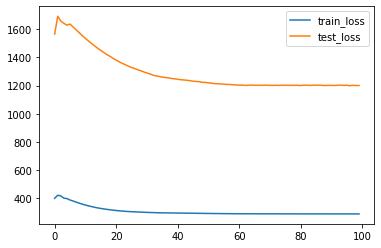

In [ ]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x_range = [i for i in range(len(train_loss))]
plt.plot(x_range, train_loss, label='train_loss')
plt.plot(x_range, test_loss, label='test_loss')
plt.legend()
plt.show()

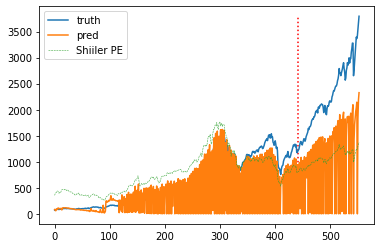

In [ ]:
total_X = np.concatenate((train_X, test_X), axis=0)
total_Y = np.concatenate((train_Y, test_Y), axis=0)
y_pred = model_lstm_dense.predict(total_X)
x_range = np.arange(len(total_X))
y_truth = total_Y
plt.plot(x_range, y_truth, label='truth')
plt.plot(x_range, y_pred, label='pred')
plt.plot(x_range, [f[1] for f in features[180:]], label='Shiiler PE', linestyle='dashed', linewidth=0.5)
plt.legend()
plt.vlines(x=len(train_X), ymin=0, ymax=max(total_Y), colors='r', linestyles='dotted')
plt.show()

# Model3: single LSTM

In [ ]:
model_lstm = get_model3(input_length=180)

In [ ]:
model_lstm.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 180, 2)]          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1)                 16        
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.compile(optimizer='adam', loss='mae')

In [ ]:
checkpoint_filepath = './checkpoints/model_weights_lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history = model_lstm.fit(train_X, train_Y, batch_size=16, epochs=100, validation_data=(test_X, test_Y), callbacks=[model_checkpoint_callback])

Epoch 1/100
28/28 [==============================] - 16s 21ms/step - loss: 584.1071 - val_loss: 2265.0425
Epoch 2/100
28/28 [==============================] - 0s 9ms/step - loss: 632.6988 - val_loss: 2265.0425
Epoch 3/100
28/28 [==============================] - 0s 9ms/step - loss: 617.8104 - val_loss: 2265.0425
Epoch 4/100
28/28 [==============================] - 0s 9ms/step - loss: 591.6457 - val_loss: 2265.0425
Epoch 5/100
28/28 [==============================] - 0s 9ms/step - loss: 671.8888 - val_loss: 2265.0425
Epoch 6/100
28/28 [==============================] - 0s 9ms/step - loss: 656.0291 - val_loss: 2265.0425
Epoch 7/100
28/28 [==============================] - 0s 9ms/step - loss: 626.1583 - val_loss: 2265.0425
Epoch 8/100
28/28 [==============================] - 0s 9ms/step - loss: 627.6303 - val_loss: 2265.0425
Epoch 9/100
28/28 [==============================] - 0s 9ms/step - loss: 590.8112 - val_loss: 2265.0425
Epoch 10/100
28/28 [==============================] - 0s 9ms/s

obviously, it is not working

In [ ]:
model_lstm_dense.save_weights('model_lstm_epochs100.h5')

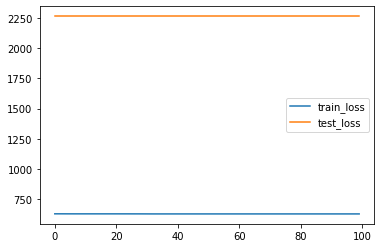

In [ ]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x_range = [i for i in range(len(train_loss))]
plt.plot(x_range, train_loss, label='train_loss')
plt.plot(x_range, test_loss, label='test_loss')
plt.legend()
plt.show()

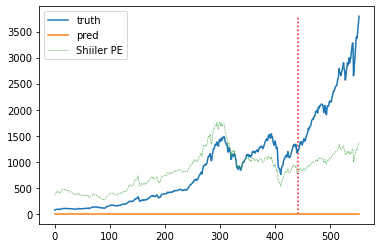

In [ ]:
total_X = np.concatenate((train_X, test_X), axis=0)
total_Y = np.concatenate((train_Y, test_Y), axis=0)
y_pred = model_lstm.predict(total_X)
x_range = np.arange(len(total_X))
y_truth = total_Y
plt.plot(x_range, y_truth, label='truth')
plt.plot(x_range, y_pred, label='pred')
plt.plot(x_range, [f[1] for f in features[180:]], label='Shiiler PE', linestyle='dashed', linewidth=0.5)
plt.legend()
plt.vlines(x=len(train_X), ymin=0, ymax=max(total_Y), colors='r', linestyles='dotted')
plt.show()

# Final model
From the training result above, LSTM + Dense is the best of the three;<br> However, due to relu, there will be too many 0 prediction. <br> So, we want to use another activation func on LSTM layer, and remove activation func on the last layer

In [22]:
model = get_model2()

In [23]:
model.load_weights('model_lstm_dense_epochs100.h5')

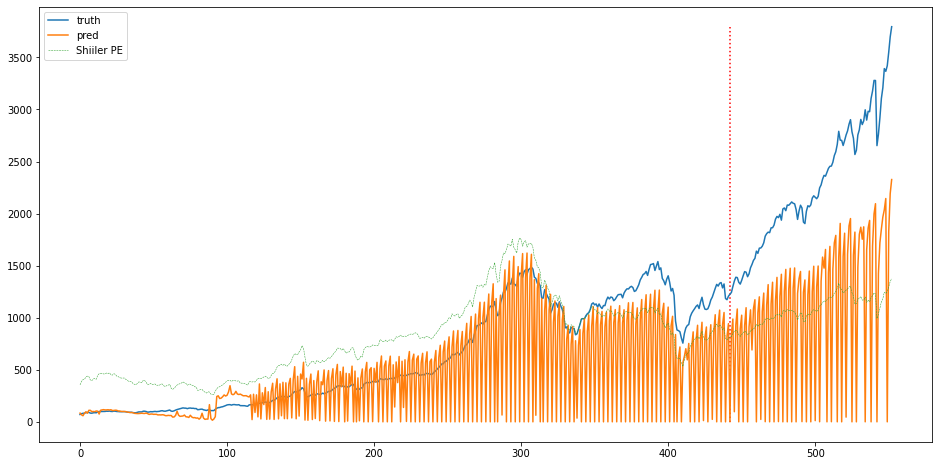

In [26]:
total_X = np.concatenate((train_X, test_X), axis=0)
total_Y = np.concatenate((train_Y, test_Y), axis=0)
y_pred = model.predict(total_X)
x_range = np.arange(len(total_X))
y_truth = total_Y
figure = plt.figure(figsize=(16, 8))
plt.plot(x_range, y_truth, label='truth')
plt.plot(x_range, y_pred, label='pred')
plt.plot(x_range, [f[1] for f in features[180:]], label='Shiiler PE', linestyle='dashed', linewidth=0.5)
plt.legend()
plt.vlines(x=len(train_X), ymin=0, ymax=max(total_Y), colors='r', linestyles='dotted')
plt.show()

the trend is what we expected, but there are too many zeros due to 'relu'

In [54]:
ipt = Input(shape=(180, 2))
lstm = LSTM(4, return_sequences=False, activation='selu')(ipt)
opt = Dense(1)(lstm)
model_new = Model(ipt, opt)


In [55]:
model_new.compile('adam', 'mae')

In [56]:
history = model_new.fit(train_X, train_Y, batch_size=16, epochs=100, validation_data=(test_X, test_Y))

Epoch 1/100
28/28 [==============================] - 8s 232ms/step - loss: 581.1803 - val_loss: 2255.9983
Epoch 2/100
28/28 [==============================] - 6s 229ms/step - loss: 617.5271 - val_loss: 2200.1816
Epoch 3/100
28/28 [==============================] - 6s 222ms/step - loss: 492.8086 - val_loss: 2089.2664
Epoch 4/100
28/28 [==============================] - 6s 223ms/step - loss: 451.1573 - val_loss: 1956.2007
Epoch 5/100
28/28 [==============================] - 6s 227ms/step - loss: 381.0530 - val_loss: 1912.2924
Epoch 6/100
28/28 [==============================] - 6s 225ms/step - loss: 363.4754 - val_loss: 1831.0293
Epoch 7/100
28/28 [==============================] - 6s 224ms/step - loss: 308.7839 - val_loss: 1753.2362
Epoch 8/100
28/28 [==============================] - 6s 225ms/step - loss: 268.7449 - val_loss: 1661.3204
Epoch 9/100
28/28 [==============================] - 6s 227ms/step - loss: 255.0464 - val_loss: 1550.9336
Epoch 10/100
28/28 [==========================

In [57]:
model_new.save_weights('model_lstm_dense_selu_100.h5')

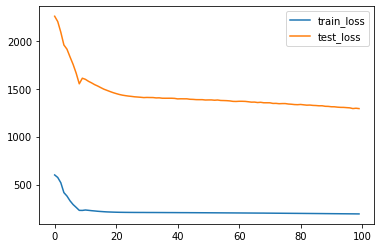

In [58]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x_range = [i for i in range(len(train_loss))]
plt.plot(x_range, train_loss, label='train_loss')
plt.plot(x_range, test_loss, label='test_loss')
plt.legend()
plt.show()

not converging yet, but anyway the performance is not bad, so we choose this as the final model

In [ ]:
total_X = np.concatenate((train_X, test_X), axis=0)
total_Y = np.concatenate((train_Y, test_Y), axis=0)
y_pred = model_new.predict(total_X)
x_range = np.arange(len(total_X))
y_truth = total_Y
figure = plt.figure(figsize=(16, 8))
plt.plot(x_range, y_truth, label='truth')
plt.plot(x_range, y_pred, label='pred')
plt.plot(x_range, [f[1] for f in features[180:]], label='Shiiler PE', linestyle='dashed', linewidth=0.5)
plt.legend()
plt.vlines(x=len(train_X), ymin=0, ymax=max(total_Y), colors='r', linestyles='dotted')
plt.show()

let's train for 500 more epochs

In [73]:
checkpoint_filepath = './checkpoints/model_weights_lstm_dense_selu_final.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
history = model_new.fit(train_X, train_Y, batch_size=8, epochs=500, validation_data=(test_X, test_Y), callbacks=[model_checkpoint_callback])

Epoch 1/500
59/59 [==============================] - 13s 226ms/step - loss: 225.1249 - val_loss: 1452.1963
Epoch 2/500
59/59 [==============================] - 13s 224ms/step - loss: 223.7903 - val_loss: 1442.7365
Epoch 3/500
59/59 [==============================] - 13s 222ms/step - loss: 222.7714 - val_loss: 1431.8135
Epoch 4/500
59/59 [==============================] - 13s 224ms/step - loss: 221.9377 - val_loss: 1419.8901
Epoch 5/500
59/59 [==============================] - 13s 226ms/step - loss: 221.0469 - val_loss: 1418.3760
Epoch 6/500
59/59 [==============================] - 13s 226ms/step - loss: 219.9111 - val_loss: 1410.0385
Epoch 7/500
59/59 [==============================] - 13s 222ms/step - loss: 219.0396 - val_loss: 1401.9989
Epoch 8/500
59/59 [==============================] - 14s 232ms/step - loss: 217.8334 - val_loss: 1396.0282
Epoch 9/500
59/59 [==============================] - 13s 226ms/step - loss: 216.9088 - val_loss: 1389.3917
Epoch 10/500
59/59 [=================

In [74]:
model_new.save_weights('/content/drive/MyDrive/model_weights_lstm_dense_selu_final.h5')

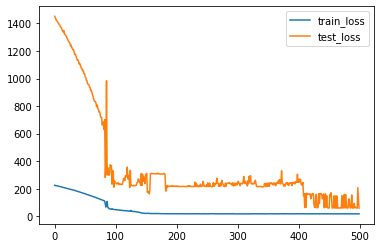

In [75]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x_range = [i for i in range(len(train_loss))]
plt.plot(x_range, train_loss, label='train_loss')
plt.plot(x_range, test_loss, label='test_loss')
plt.legend()
plt.show()

# evaluation

predicting on the whole dataset

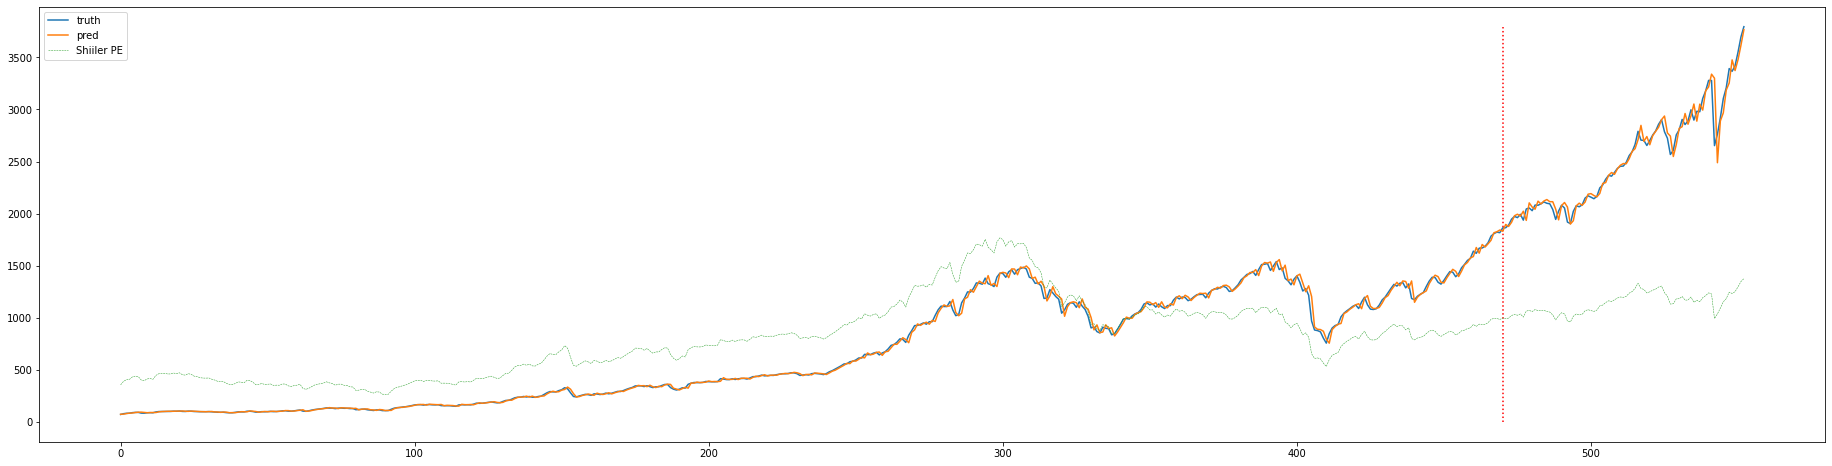

In [77]:
total_X = np.concatenate((train_X, test_X), axis=0)
total_Y = np.concatenate((train_Y, test_Y), axis=0)
y_pred = model_new.predict(total_X)
x_range = np.arange(len(total_X))
y_truth = total_Y
figure = plt.figure(figsize=(32, 8))
plt.plot(x_range, y_truth, label='truth')
plt.plot(x_range, y_pred, label='pred')
plt.plot(x_range, [f[1] for f in features[180:]], label='Shiiler PE', linestyle='dashed', linewidth=0.5)
plt.legend()
plt.vlines(x=len(train_X), ymin=0, ymax=max(total_Y), colors='r', linestyles='dotted')
plt.show()

get the error on the test set

In [86]:
y_pred = model_new.predict(test_X).reshape(-1, )
y_truth = test_Y
error = abs(y_truth - y_pred)
error_rate = [e / y for e, y in zip(error, y_truth)]
mean_error_rate = np.mean(error_rate)

In [91]:
mean_error_rate

0.02328918539276374

# add noise on test set:

I assume the noise won't affect anything, because 

In [96]:
data[data['Date']=='1-Aug-80'].index

Int64Index([247], dtype='int64')

In [104]:
new_test_x_start_idx = 247-180
new_test_y_start_idx = 247

In [105]:
new_test_data_X = np.array([features[i:i+180] for i in range(new_test_x_start_idx, len(features)-180)])
new_test_data_Y = np.array(data['label'].values)[new_test_y_start_idx:]
assert len(data_X) == len(data_Y)
new_test_data_X.shape, new_test_data_Y.shape

((486, 180, 2), (486,))

In [125]:
def add_noise(dev):
    test_data_noise_x = new_test_data_X.copy()
    noise_0 = np.random.normal(0, dev, 18)
    noise_1 = np.random.normal(0, dev, 18)
    for i in range(len(test_data_noise_x)):
        x_idx = np.arange(180)
        np.random.shuffle(x_idx)
        x_idx = x_idx[0:18]
        for j, idx in enumerate(x_idx):
            test_data_noise_x[i,idx,0] += noise_0[j]
            test_data_noise_x[i,idx,1] += noise_1[j]
    return test_data_noise_x


In [111]:
res = pd.DataFrame(index=data['Date'].values[247:], columns=['stdev-'+str(dev) for dev in [0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]])

In [112]:
res

,stdev-0,stdev-0.001,stdev-0.002,stdev-0.003,stdev-0.005,stdev-0.01,stdev-0.02,stdev-0.03,stdev-0.05,stdev-0.1
1-Aug-80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-Sep-80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-Oct-80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-Nov-80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-Dec-80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1-Sep-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-Oct-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-Nov-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-Dec-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:

for dev in [0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]:
    test_data_noise_x = add_noise(dev)
    y_pred = model_new.predict(test_data_noise_x).reshape(-1, )
    y_truth = new_test_data_Y
    error = abs(y_truth - y_pred)
    error_rate = [e / y for e, y in zip(error, y_truth)]
    res['stdev-'+str(dev)] = error_rate

In [128]:
res

,stdev-0,stdev-0.001,stdev-0.002,stdev-0.003,stdev-0.005,stdev-0.01,stdev-0.02,stdev-0.03,stdev-0.05,stdev-0.1
1-Aug-80,0.012112,0.012112,0.012112,0.012132,0.012112,0.012112,0.012112,0.012108,0.012105,0.012112
1-Sep-80,0.007876,0.007875,0.007876,0.007876,0.007863,0.007768,0.007864,0.007768,0.007891,0.007940
1-Oct-80,0.013840,0.013839,0.013840,0.013840,0.013840,0.013839,0.013841,0.013839,0.013721,0.013840
1-Nov-80,0.024615,0.024615,0.024615,0.024615,0.024605,0.024615,0.024615,0.024757,0.024192,0.024615
1-Dec-80,0.035622,0.035622,0.035611,0.035622,0.035630,0.035622,0.035631,0.035622,0.035622,0.035622
...,...,...,...,...,...,...,...,...,...,...
1-Sep-20,0.032570,0.032570,0.032570,0.032570,0.032570,0.032570,0.032570,0.032570,0.032570,0.032570
1-Oct-20,0.013441,0.013441,0.013441,0.013441,0.013441,0.013441,0.013441,0.013441,0.013441,0.013425
1-Nov-20,0.020494,0.020494,0.020494,0.020494,0.020494,0.020489,0.020493,0.020492,0.020494,0.020494
1-Dec-20,0.021649,0.021649,0.021649,0.021649,0.021649,0.021649,0.021649,0.021649,0.021649,0.021655
